Now that we have implemented the 3 important cases:

- EMCEE + Simulation
- EMCEE + DeepONet
- NumPyro + DeepONet

And saved its outputs with ArViz, let's now load each one and to a combined analysis

In [1]:
import arviz as az
import matplotlib.pyplot as plt

In [8]:
emcee_sim = az.from_netcdf("../../outputs/inference_data_emcee+simulator.nc")
emcee_net = az.from_netcdf("../../outputs/inference_data_emcee+deeponet.nc")
numpyro_net = az.from_netcdf("../../outputs/inference_data_numpyro.nc")

In [31]:
# Number of samples per chunk
chunk_size = 100
rhat_series = {}
setups = ["emcee+odeint", "emcee+deeponet", "numpyro+deeponet"]


for setup,idata in zip(setups, [emcee_sim, emcee_net, numpyro_net]):
    
    num_samples = idata.posterior.sizes["draw"]
    rhat_values = []
    
    for i in range(chunk_size, num_samples + 1, chunk_size):
        # Slice the samples up to i-th sample
        partial_idata = idata.sel(draw=slice(0, i))
        # Compute R-hat for this subset
        rhat = az.rhat(partial_idata)
        # Average R-hat over parameters (or select specific parameter)
        rhat_mean = rhat.to_array().mean().item()
        rhat_values.append(rhat_mean)

    rhat_series[setup] = rhat_values

In [14]:
list(map(len, rhat_series.values()))

[100, 100, 100]

In [52]:
steps = list(range(chunk_size, num_samples + 1, chunk_size))

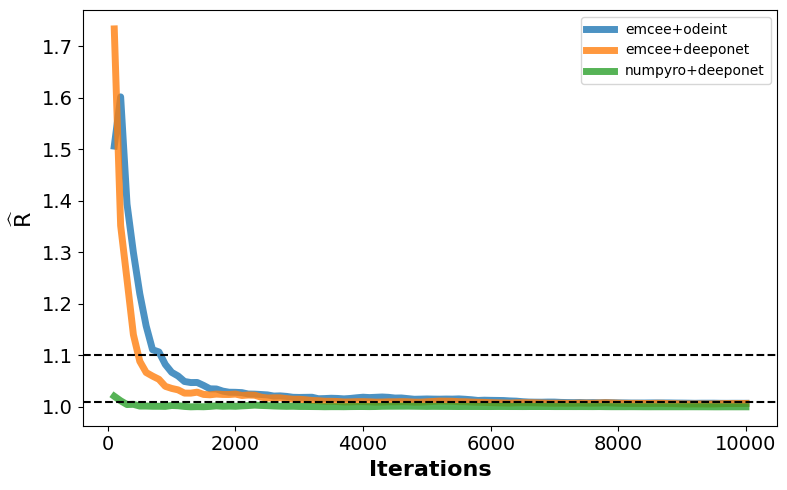

In [53]:
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(8, 5))

for s in setups:
    ax.plot(steps, rhat_series[s], label=s, lw=5, alpha=0.8)


# ax.set_box_aspect(1)
ax.set_xlabel(r'Iterations', fontsize=16, weight='bold', color='k')
ax.set_ylabel(r'$\widehat{\mathsf{R}}$', fontsize=16, weight='bold',
              color='k')
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%2.1f'))
ax.legend(fontsize=14, facecolor='white',
          framealpha=0.5)

ax.legend()
ax.axhline(y=1.1, ls="--", c="k")
ax.axhline(y=1.01, ls="--", c="k")

# ax.set_title(r"$\widehat{R}$")

plt.tight_layout()
fig.savefig("../../outputs/rhat_evolution.svg")

In [58]:
az.summary(emcee_sim, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var_0,1.485,0.220,1.317,1.626,0.006,0.038,1749.0,2932.0,1.01
var_1,0.315,0.241,0.186,0.406,0.008,0.043,1411.0,2429.0,1.01
var_2,1.179,0.163,0.885,1.466,0.004,0.006,1491.0,4834.0,1.01
var_3,1.216,0.311,0.683,1.722,0.007,0.020,1811.0,3617.0,1.01


In [57]:
az.summary(emcee_net, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var_0,1.480,0.119,1.321,1.628,0.003,0.019,1961.0,4967.0,1.00
var_1,0.303,0.175,0.201,0.415,0.004,0.035,1520.0,4050.0,1.01
var_2,1.150,0.168,0.838,1.459,0.004,0.005,1761.0,5468.0,1.00
var_3,1.252,0.270,0.732,1.773,0.006,0.005,1790.0,4776.0,1.01


In [59]:
az.summary(numpyro_net, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.293,0.057,0.199,0.410,0.001,0.000,7890.0,9870.0,1.0
k,1.475,0.078,1.323,1.625,0.001,0.001,6565.0,7779.0,1.0
v0,1.249,0.265,0.753,1.787,0.003,0.002,6831.0,7425.0,1.0
x0,1.154,0.157,0.850,1.461,0.002,0.001,6969.0,9115.0,1.0
